In [17]:
using KitMSA
using DelimitedFiles
using FastaIO
using DataFrames
using PyPlot
using StatsBase
using XLSX
using CSV
using LaTeXStrings
using DCAUtils

## Natural alignment, model and experimental sequences

### Aligning 

An important point about aligning the sequences. The full-length sequences of the family have ~ 260 sites. We have build an hmm to align them based on 14 structurally aligned sequences. This hmm has 229 sites, meaning that all sequences aligned with it have 229 sites. After aligning, we removed some flank sites (those with more than 75% of gaps), thus we have built a natural alignment of 222 sites. This is the alignment used to train the model, hence all sequences generated by the model have lenght 222. The same alignment procedure must be done for any "new" natural/experimental sequence for it to have the correct length, i.e. the experimental sequences shared by Ayse for this experiment. The "flank sites" are [1, 2, 3, 4, 227, 228, 229].


This is the function that I have used to remove columns from already aligned sequences, in case you will need in the future. 

In [2]:
function remove_specific_cols(fastapath::AbstractString, cols::Array{Int64, 1}, 
        outpath::AbstractString)
    
    MSA = fasta2matrix(fastapath)
    M, N = size(MSA)
    
    col_to_rem = cols
    col_to_keep = [i for i in 1:N if i ∉ col_to_rem]                        

                    
    count_removed_cols = length(col_to_rem)
    
    f = FastaReader(fastapath)
    for (desc, seq_string) in f
        writefasta(outpath, [(desc, seq_string[col_to_keep])], "a")
    end
    
    close(f)
    plural_flag = "s"
    verb_flag = "ve"
    if count_removed_cols == 1
        plural_flag = ""
        verb_flag = "s"
    end

    println("$(count_removed_cols) column$(plural_flag) ha$(verb_flag) been removed.")
    return outpath,col_to_rem
end


remove_specific_cols (generic function with 1 method)

### WT Sequences and natural alignment

In [4]:
# VIM-2 (there is a DMS of this sequence)
VIM = fasta2matrix("../../files_nobu_evolution_exp/wts/VIM2_V185I_hmmstruct_symfrac03_max075flankcolgaps.fasta")

# NDM-1 (there is a DMS of this sequence)
NDM = fasta2matrix("../../files_nobu_evolution_exp/wts/NDM1_hmmstruct_symfrac03_max075flankcolgaps.fasta")

# IMP-1, BCII-1 (those 2 are clinically relevant, DMS are likely being done soon. 
# We have another work with Nobu in which they are testing the funcionality of dozens of sequences generated aroud those 2, 
# at distances 11%, 22% and 33%)
IMP = fasta2matrix("../../files_nobu_evolution_exp/wts/IMP-1.fasta")
BCII = fasta2matrix("../../files_nobu_evolution_exp/wts/IMP-1.fasta")

# Natural alignment (Our biggest alignment yet on this B1 family)
MSA_nat = fasta2matrix("../../files_nobu_evolution_exp/natural_seqs/B1_all_Sevan_hmm03_max010rowgaps_max075flankcolgaps.fasta")

# Same alignment, in which all sequence with sequence identity >80% to the previous 4 wts have been removed.
# This is the alignment used to train the model. 
MSA_train = fasta2matrix("../../files_nobu_evolution_exp/natural_seqs/B1_all_Sevan_hmm03_max010rowgaps_max075flankcolgaps_max080wtid.fasta")

# Alignment of all AW, NDL and NDH sequences from the experiment sent in 2022 Ayse.
MSA_exp = fasta2matrix("../../files_nobu_evolution_exp/exp/all_aa_seq_neutral_drift_2022_CDHIT100_aligned_noflankgaps.fasta")
;


### Model

In [6]:
# This model has been trained on "MSA_train" with PCD-40. NI stands for Not Integrated.
h, J = extract_params("../../files_nobu_evolution_exp/params/Parameters_B1all_NI.dat.gz")

# This is the same model as before, but we have integrated the DMS data of VIM-2 and NDM-1. 
#This means that now there is a Spearman correlation of about 0.93 with the DMS, instead of ~0.67. YI stands for Yes Integrated.
h_int, J_int = extract_params("../../files_nobu_evolution_exp/params/Parameters_B1all_YI.dat.gz")
;

In [16]:
ps = exp.(h_int) ./ sum(exp.(h_int));
fs = compute_weighted_frequencies(Int8.(MSA_train), 22, 0.2)[1];

In [20]:
cor(ps[:], fs[:])

LoadError: UndefVarError: `fs` not defined

### Experimental sequences

In [8]:
# Read the MIC values of the experimental sequences
MIC = readdlm("../../files_nobu_evolution_exp/MIC/AW_NDL_NDH_variant_AMP_MIC.fasta")[1:end, [1, 3]]

# Normalize the values, such that the wt has MIC 0
MIC[:, 2] = Float64.(log2.(MIC[:, 2]) .- log2(MIC[1, 2]))

# Create a dataframe from the MIC files
df_MIC = DataFrame(MIC, :auto)
rename!(df_MIC , "x1" => "name", "x2" => "MIC")

# Round number starts from -18 and arrives to 100. -18 because there have been 18 rounds of Adaptive Walk, 
# and 100 rounds of Neutral Drift. Round 0 corresponds to sequences with high resistance. 
ll = length(df_MIC.name)
n_round = [0 for i in 1:ll]

# Trajectory is either WT, AW, NDH or NDL
traj = ["test" for i in 1:ll]

for (i, name) in enumerate(df_MIC.name)
    if name != "VIM2_WT_pos2_removed"
        traj[i], rr, _ = split(name, "_")
        if traj[i] == "AW"
            n_round[i] = parse(Int64, rr) - 18
        else
            n_round[i] = parse(Int64, rr) 
        end
    else
        traj[i] = "WT"
        n_round[i] = -18
    end
end
      
df_MIC[!, "round"] = n_round
df_MIC[!, "traj"] = traj
df_MIC


# Create a dataframe from the alignment
df_Seqs = DataFrame()
df_Seqs[!, "seq"] = [MSA_exp[i, :] for i in 1:size(MSA_exp, 1)]

# Extract the name of the sequences
names = readdlm("../../files_nobu_evolution_exp/exp/all_aa_seq_neutral_drift_2022_CDHIT100_aligned_noflankgaps.fasta")[ 1:4:end , 4]
names = [string[1: (end-2)] for string in names]
df_Seqs[!, "name"] = names

# Match the sequences with their MIC, round ecc..
df_Final = innerjoin(df_MIC, df_Seqs, on = [:name])

# Add the sequence energy
en = [energy(h, J, s) for s in df_Final.seq]
df_Final[!, "energy"] = en

# Add the hamming distance
hd = [KitMSA.my_hamming(s, VIM) for s in df_Final.seq]
df_Final[!, "distance"] = hd

# Final dataframe
df_Final

Row,name,MIC,round,traj,seq,energy,distance
,Any,Any,Int64,String,Array…,Float64,Int64
1,AW_3_4,4.0,-15,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",16.3048,5
2,VIM2_WT_pos2_removed,0.0,-18,WT,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",9.45377,1
3,AW_3_7,5.0,-15,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",19.7691,7
4,AW_3_1,5.0,-15,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",16.4372,4
5,AW_3_5,4.0,-15,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",16.0501,5
6,AW_3_8,5.0,-15,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",11.5743,5
7,AW_18_3,6.0,0,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 15, 7, 17, 17, 9, 18, 18, 9, 1, 7]",12.9498,16
8,AW_6_2,6.0,-12,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",5.10373,5
9,AW_9_1,7.0,-9,AW,"Int16[21, 21, 21, 6, 4, 18, 15, 10, 20, 14 … 9, 7, 17, 17, 12, 18, 18, 9, 1, 7]",11.1193,9


In [13]:
using JLD2

In [14]:
@save "../../data_frame_ayse.jld2" df_Final

## Plot results

The dataframe df_Final contains all the information about the sequences for which we have a MIC value. Notice that there are some experimental sequences which do not have a MIC value, and they are not in the dataframe. These are ~100 sequences. 

### Average energy and MIC over each round

In [9]:
quantity_to_avg = ["MIC", "energy",] 
vec_names =  vcat(["traj", "round"], vcat(["mean_$(qq)" for qq in quantity_to_avg], ["std_$(qq)" for qq in quantity_to_avg]))
nv = length(vec_names)
df_mean = DataFrame(vec_names .=> vcat(["test", 0],  [0. for i in 1:(nv-2)]  )   ) 


for tt in unique(df_Final.traj)
    for rr in unique(df_Final[df_Final.traj .== tt, "round"])
        vals = [tt, rr]
        for nn in ["mean", "std"]
            for qq in quantity_to_avg
                vv = df_Final[ (df_Final.traj .== tt) .&  (df_Final.round .== rr), qq  ]
                mm = mean(vv)
                stdd = std(vv)
                if nn == "mean"
                    push!(vals, mm)
                else
                    push!(vals, stdd)
                end
            end
        end
        push!(df_mean, vals)
    end
end

# This dataframe contains the average and std of all quantities, divided by round and trajetory
df_mean = df_mean[2:end, :]
sort!(df_mean, :round)


Row,traj,round,mean_MIC,mean_energy,std_MIC,std_energy
,String,Int64,Float64,Float64,Float64,Float64
1,WT,-18,0.0,9.45377,NaN,NaN
2,AW,-15,4.77778,16.535,0.666667,2.93819
3,AW,-12,6.0,15.258,0.0,6.16086
4,AW,-9,6.83333,11.0251,0.408248,0.411591
5,AW,0,6.28571,12.1482,0.46291,4.17496
6,NDL,1,4.5,15.0685,2.78193,4.39489
7,NDL,2,4.08333,16.5575,2.12473,5.21973
8,NDL,5,1.75,21.7725,2.53138,7.53898
9,NDH,5,6.14286,9.96781,0.358569,4.46529


### Plot average MIC and energy over the rounds

If you redo this plot with the integrated model, you will notice a distortion in the energy of the sequences. This is caused by the interation procedure, which creates a "hole" in landscape around the WT. This means that every mutation around it becomes comparatively deleterious. Our hope is that the relative effect of the mutations remains the same, or even better, improves.

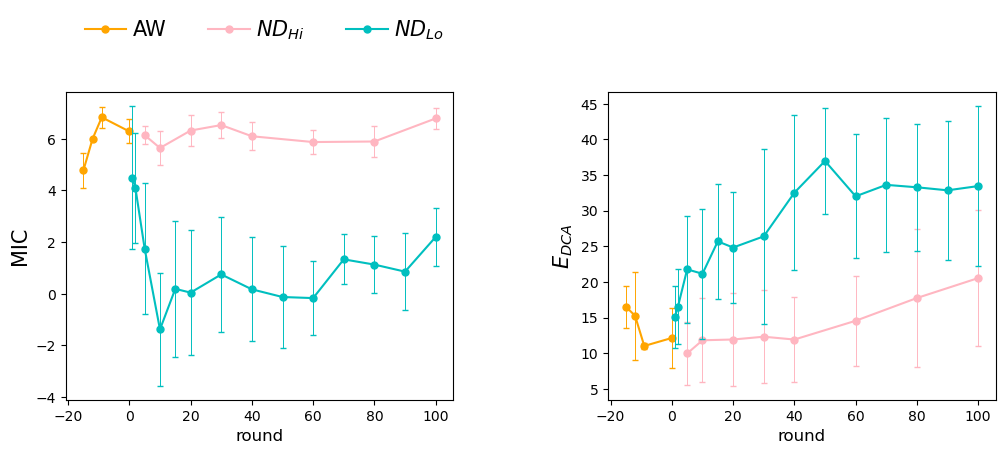

PyObject <matplotlib.legend.Legend object at 0x7f7208a0ad90>

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
fig.subplots_adjust(wspace = 0.3, hspace = 0.5)
var_vec = ["mean_MIC", "mean_energy"]
var_vec_std = ["std_MIC", "std_energy"]
sign_vec = [1, 1]
tit_vec = ["MIC", L"E_{DCA}"]
cls = ["orange", "lightpink", "c"]
lab = ["AW", L"ND_{Hi}", L"ND_{Lo}"]


subplots_adjust(hspace = 0.4, wspace = 0.4)


for (i, axs) in enumerate(ax)
    
    mod_mean = var_vec[i]
    mod_std = var_vec_std[i]
    sig = sign_vec[i]
    
    #axs.set_title(tit_vec[i], fontsize = 15)
    axs.set_ylabel(tit_vec[i], fontsize = 15)
    for (j, tt) in enumerate(["AW", "NDH", "NDL"])
        
        cc = cls[j]
        axs.plot(df_mean[df_mean.traj .== tt, :round] , 
            sig*df_mean[df_mean.traj .== tt, mod_mean],label = lab[j], marker = "o", color = cc, markersize = 5)
        
        axs.errorbar(df_mean[df_mean.traj .== tt, :round], sig*df_mean[df_mean.traj .== tt, mod_mean],
            df_mean[df_mean.traj .== tt, mod_std], linestyle = "", color = cc, 
            linewidth = 0.7, capsize = 2)

    end
    
  
   # axs.plot(df_mean[df_mean.traj .== "NDH", :round] , 
   #sig*df_mean[df_mean.traj .== "NDH", mod_mean], label = "NDH", marker = "o")

    #axs.plot(df_mean[df_mean.traj .== "NDL", :round] , 
    #    sig*df_mean[df_mean.traj .== "NDL", mod_mean], label = "NDL", marker = "o")
    
    axs.set_xlabel("round", fontsize = 12)
    #axs.legend()
end

ax[1].legend(bbox_to_anchor=(0, 1.3), loc="upper left", fontsize = 15, ncol = 3, 
    frameon = false, handletextpad = 0.3)


### Plot MIC and energy vs Hamming distance

As you can already see from this plot here, the evolution at higher dose of antibiotic proceed at a slower rate, 
as less mutations were accepted at each round. 

You can also notice that sometimes sequences at later rounds wrt round 0 (or 18 of AW), have less mutations that those at round 0. This might be caused by the alignment procedure. In fact aligning removes ~40 sites where mutations can happen, but which we do not see.

In [11]:
@show mean(df_Final[df_Final.round .== 0, :distance])
sort(df_Final[df_Final.round .== 1, :distance])

mean(df_Final[df_Final.round .== 0, :distance]) = 14.380952380952381


24-element Vector{Int64}:
 11
 12
 13
 13
 14
 14
 14
 14
 15
 15
 15
 15
 15
 16
 16
 16
 16
 16
 16
 17
 17
 18
 19
 19

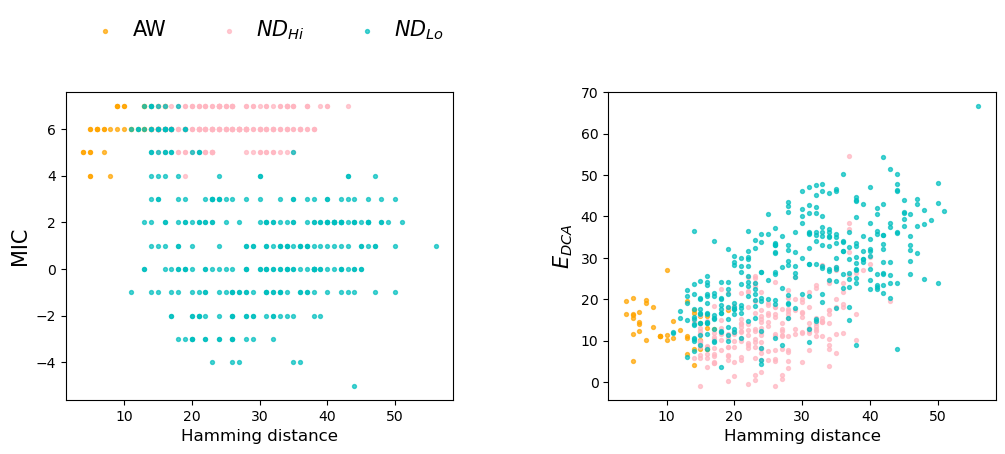

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
fig.subplots_adjust(wspace = 0.3, hspace = 0.5)
tit_vec = ["MIC", L"E_{DCA}"]
quantity = [:MIC, :energy]

cls = ["orange", "lightpink", "c"]

subplots_adjust(hspace = 0.4, wspace = 0.4)

for (i, axs) in enumerate(ax)
    
    axs.set_ylabel(tit_vec[i], fontsize = 15)
    for (j, tt) in enumerate(["AW", "NDH", "NDL"])
        
        cc = cls[j]
        axs.scatter(df_Final[df_Final.traj .== tt, :distance],
         df_Final[df_Final.traj .== tt, quantity[i]],
        label = lab[j],  color = cc, alpha = 0.7, s = 8)
    end

    axs.set_xlabel("Hamming distance", fontsize = 12)
end

ax[1].legend(bbox_to_anchor=(0, 1.3), loc="upper left", fontsize = 15, ncol = 3, 
    frameon = false, handletextpad = 0.3)
;